In [ ]:
import pandas as pd
import sqlite3

#Load CSV - by importing the CSV into a pandas DataFrame
df=pd.read_csv('inventory_forecasting.csv')

#Preview df
df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0096,Toys,West,158,134,142,152.36,40.88,5,Sunny,1,42.39,Winter
1,2022-01-01,S001,P0016,Clothing,East,189,127,125,150.47,90.78,0,Rainy,0,84.16,Winter
2,2022-01-01,S001,P0031,Electronics,West,75,48,39,68.62,13.99,20,Rainy,0,12.67,Winter
3,2022-01-01,S001,P0159,Electronics,West,161,74,71,75.46,84.92,10,Snowy,0,83.03,Winter
4,2022-01-01,S001,P0129,Furniture,South,135,66,69,67.18,19.66,0,Cloudy,0,20.55,Winter


In [ ]:
#To check for null values
df.isnull().sum()

Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64

In [ ]:
#Rename columns to SQL-friendly format
df.columns=[c.strip().replace(' ','_').replace('/','_') for c in df.columns]

df.columns

Index(['Date', 'Store_ID', 'Product_ID', 'Category', 'Region',
       'Inventory_Level', 'Units_Sold', 'Units_Ordered', 'Demand_Forecast',
       'Price', 'Discount', 'Weather_Condition', 'Holiday_Promotion',
       'Competitor_Pricing', 'Seasonality'],
      dtype='object')

In [ ]:
#Create in-memory SQLite DB
conn=sqlite3.connect('retail.db')

#Write table to SQLite, named 'InventoryData'
df.to_sql('InventoryData',conn,if_exists='replace',index=False)

109500

In [ ]:
gquery_1="""
SELECT distinct Category FROM InventoryData
"""
pd.read_sql_query(gquery_1, conn)

In [ ]:
gquery_1="""
SELECT distinct Category FROM InventoryData
"""
pd.read_sql_query(gquery_1, conn)

,Category
0,Toys
1,Clothing
2,Electronics
3,Furniture
4,Groceries


In [ ]:
gquery_1="""
SELECT DISTINCT Category,Product_ID
FROM InventoryData
"""
pd.read_sql_query(gquery_1, conn)

In [ ]:

gquery_2 = """
SELECT 
    Store_ID,

    -- Electronics KPIs
    SUM(CASE WHEN Category = 'Electronics' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Electronics' THEN Units_Sold + Inventory_Level ELSE 0 END), 0) AS Electronics_Sell_Through_Rate,

    SUM(CASE WHEN Category = 'Electronics' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Electronics' THEN Inventory_Level ELSE 0 END), 0) AS Electronics_Inventory_Turnover,

    SUM(CASE WHEN Category = 'Electronics' THEN Units_Ordered ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Electronics' THEN Units_Sold ELSE 0 END), 0) AS Electronics_Order_Sales_Ratio,

    -- Grocery KPIs
    SUM(CASE WHEN Category = 'Groceries' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Groceries' THEN Units_Sold + Inventory_Level ELSE 0 END), 0) AS Grocery_Sell_Through_Rate,

    SUM(CASE WHEN Category = 'Groceries' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Groceries' THEN Inventory_Level ELSE 0 END), 0) AS Grocery_Inventory_Turnover,

    SUM(CASE WHEN Category = 'Groceries' THEN Units_Ordered ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Groceries' THEN Units_Sold ELSE 0 END), 0) AS Grocery_Order_Sales_Ratio,

    -- Clothing KPIs
    SUM(CASE WHEN Category = 'Clothing' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Clothing' THEN Units_Sold + Inventory_Level ELSE 0 END), 0) AS Clothing_Sell_Through_Rate,

    SUM(CASE WHEN Category = 'Clothing' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Clothing' THEN Inventory_Level ELSE 0 END), 0) AS Clothing_Inventory_Turnover,

    SUM(CASE WHEN Category = 'Clothing' THEN Units_Ordered ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Clothing' THEN Units_Sold ELSE 0 END), 0) AS Clothing_Order_Sales_Ratio,

    -- Furniture KPIs
    SUM(CASE WHEN Category = 'Furniture' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Furniture' THEN Units_Sold + Inventory_Level ELSE 0 END), 0) AS Furniture_Sell_Through_Rate,

    SUM(CASE WHEN Category = 'Furniture' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Furniture' THEN Inventory_Level ELSE 0 END), 0) AS Furniture_Inventory_Turnover,

    SUM(CASE WHEN Category = 'Furniture' THEN Units_Ordered ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Furniture' THEN Units_Sold ELSE 0 END), 0) AS Furniture_Order_Sales_Ratio,

        -- Toys KPIs
    SUM(CASE WHEN Category = 'Toys' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Toys' THEN Units_Sold + Inventory_Level ELSE 0 END), 0) AS Toys_Sell_Through_Rate,

    SUM(CASE WHEN Category = 'Toys' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Toys' THEN Inventory_Level ELSE 0 END), 0) AS Toys_Inventory_Turnover,

    SUM(CASE WHEN Category = 'Toys' THEN Units_Ordered ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Toys' THEN Units_Sold ELSE 0 END), 0) AS Toys_Order_Sales_Ratio

FROM InventoryData
GROUP BY Store_ID;
"""

pd.read_sql_query(gquery_2, conn)

,Store_ID,Electronics_Sell_Through_Rate,Electronics_Inventory_Turnover,Electronics_Order_Sales_Ratio,Grocery_Sell_Through_Rate,Grocery_Inventory_Turnover,Grocery_Order_Sales_Ratio,Clothing_Sell_Through_Rate,Clothing_Inventory_Turnover,Clothing_Order_Sales_Ratio,Furniture_Sell_Through_Rate,Furniture_Inventory_Turnover,Furniture_Order_Sales_Ratio
0,S001,0.392046,0.644862,0.993211,0.399704,0.665845,0.993477,0.404875,0.680320,0.997225,0.395871,0.655276,0.996854
1,S002,0.391413,0.643149,0.991675,0.399909,0.666414,0.996116,0.405227,0.681313,0.995836,0.394297,0.650973,0.995700
2,S003,0.391222,0.642635,0.994203,0.403367,0.676072,0.996752,0.405605,0.682382,0.996715,0.397444,0.659598,0.991541
3,S004,0.390610,0.640984,0.994957,0.401490,0.670816,0.996436,0.405653,0.682520,0.996307,0.395841,0.655193,0.994944
4,S005,0.391942,0.644579,0.995139,0.404065,0.678035,0.992473,0.405528,0.682166,0.999823,0.396987,0.658338,0.995055


In [ ]:
gquery_3 = """
SELECT 
    Store_ID,
    Product_ID,

    SUM(Units_Sold) * 1.0 / 
    NULLIF(SUM(Units_Sold + Inventory_Level), 0) AS Sell_Through_Rate,

    SUM(Units_Sold) * 1.0 / 
    NULLIF(SUM(Inventory_Level), 0) AS Inventory_Turnover,

    SUM(Units_Ordered) * 1.0 / 
    NULLIF(SUM(Units_Sold), 0) AS Order_Sales_Ratio

FROM InventoryData
GROUP BY Store_ID, Product_ID;
"""
pd.read_sql_query(gquery_3, conn)

In [ ]:
gquery_4 = """
SELECT *
FROM (
    SELECT 
        Store_ID,
        Product_ID,

        SUM(Units_Sold) * 1.0 / 
        NULLIF(SUM(Units_Sold + Inventory_Level), 0) AS Sell_Through_Rate,

        SUM(Units_Sold) * 1.0 / 
        NULLIF(SUM(Inventory_Level), 0) AS Inventory_Turnover,

        SUM(Units_Ordered) * 1.0 / 
        NULLIF(SUM(Units_Sold), 0) AS Order_Sales_Ratio

    FROM InventoryData
    GROUP BY Store_ID, Product_ID
) AS sub
WHERE Order_Sales_Ratio > 1 OR Order_Sales_Ratio < 0.8;
"""

df = pd.read_sql_query(gquery_4, conn)


In [ ]:
#Current Stock per Product per Store
query1_storewise = """
SELECT Product_ID, Store_ID, Inventory_Level
FROM InventoryData
WHERE Date = (SELECT MAX(Date) FROM InventoryData)
ORDER BY Product_ID, Store_ID;
"""
pd.read_sql_query(query1_storewise, conn)

,Product_ID,Store_ID,Inventory_Level
0,P0016,S001,111
1,P0016,S002,277
2,P0016,S003,228
3,P0016,S004,248
4,P0016,S005,240
...,...,...,...
145,P0187,S001,245
146,P0187,S002,115
147,P0187,S003,193
148,P0187,S004,130


In [ ]:
#Low Inventory Detection, triggering a restock alert
query2= """
SELECT Date, Product_ID, Store_ID, Inventory_Level
FROM InventoryData
WHERE Inventory_Level < Demand_Forecast
ORDER BY Date;
"""
pd.read_sql_query(query2, conn)

,Date,Product_ID,Store_ID,Inventory_Level
0,2022-01-01,P0116,S001,53
1,2022-01-01,P0067,S001,101
2,2022-01-01,P0017,S001,70
3,2022-01-01,P0016,S002,210
4,2022-01-01,P0129,S002,87
...,...,...,...,...
16267,2023-12-31,P0126,S004,67
16268,2023-12-31,P0171,S005,139
16269,2023-12-31,P0187,S005,195
16270,2023-12-31,P0153,S005,87


In [ ]:
#7-Day Rolling Average
#Approximates product demand
query3="""
SELECT Product_ID,
       ROUND(AVG(Units_Sold),2) AS Avg_7Day_Sales
FROM InventoryData
WHERE Date>=(
   SELECT DATE(MAX(Date), '-6 day')
   FROM InventoryData
)
GROUP BY Product_ID
ORDER BY Avg_7Day_Sales DESC;
"""
pd.read_sql_query(query3, conn)

,Product_ID,Avg_7Day_Sales
0,P0016,135.89
1,P0133,133.94
2,P0187,133.60
3,P0125,132.31
4,P0057,132.17
5,P0061,127.77
6,P0126,127.74
7,P0066,127.51
8,P0178,123.03
9,P0046,121.80


In [ ]:
#Inventory Turnover
#High turnover=fast-moving product, constantlu restocking
query4="""
SELECT Product_ID,
       SUM(Units_Sold) as Total_Sales,
       AVG(Inventory_Level) as Avg_Inventory,
       ROUND(SUM(Units_Sold)/AVG(Inventory_Level),2) AS Inventory_Turnover
FROM InventoryData
GROUP BY Product_ID
ORDER BY Inventory_Turnover DESC;
"""
pd.read_sql_query(query4, conn)

,Product_ID,Total_Sales,Avg_Inventory,Inventory_Turnover
0,P0046,386805,154.506301,2503.49
1,P0133,385843,154.356986,2499.68
2,P0057,387209,155.087945,2496.71
3,P0178,384440,153.986575,2496.58
4,P0187,385583,154.869315,2489.73
5,P0066,384764,154.667123,2487.69
6,P0125,385137,154.882192,2486.64
7,P0061,384668,154.775342,2485.33
8,P0069,382968,154.473151,2479.19
9,P0016,384509,155.221096,2477.17


In [ ]:
#Ranks products by average daily sales volume
query5 = """
SELECT Product_ID,
       AVG(Units_Sold) AS Avg_Sales_Per_Day
FROM InventoryData
GROUP BY Product_ID
ORDER BY Avg_Sales_Per_Day DESC;
"""
pd.read_sql_query(query5, conn)

,Product_ID,Avg_Sales_Per_Day
0,P0057,106.084658
1,P0046,105.973973
2,P0133,105.710411
3,P0187,105.639178
4,P0125,105.516986
5,P0066,105.414795
6,P0061,105.388493
7,P0016,105.344932
8,P0178,105.326027
9,P0069,104.922740


In [ ]:
#Promotion Impact
#Compares avg sales b/w promotion and non-promotion periods
query6 = """
SELECT Holiday_Promotion,
       AVG(Units_Sold) AS Avg_Units_Sold
FROM InventoryData
GROUP BY Holiday_Promotion;
"""
pd.read_sql_query(query6, conn)

,Holiday_Promotion,Avg_Units_Sold
0,0,93.839904
1,1,113.055545


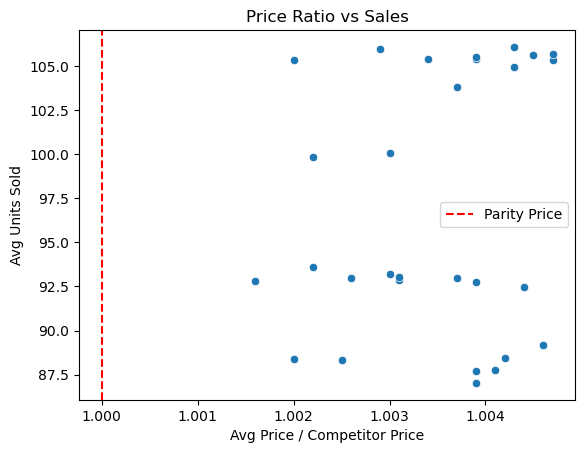

In [ ]:
#Price Competitivness vs Sales
#Analyzes whether being cheaper correlates with more units solds
import seaborn as sns
import matplotlib.pyplot as plt

query7a= """
SELECT Product_ID,
       ROUND(AVG(Price / Competitor_Pricing), 4) AS Avg_Price_Ratio,
       AVG(Units_Sold) AS Avg_Units_Sold
FROM InventoryData
WHERE Competitor_Pricing > 0
GROUP BY Product_ID;
"""
df_price_effect = pd.read_sql_query(query7a, conn)

sns.scatterplot(data=df_price_effect, x='Avg_Price_Ratio', y='Avg_Units_Sold')
plt.axvline(1, color='red', linestyle='--', label='Parity Price')
plt.title('Price Ratio vs Sales')
plt.xlabel('Avg Price / Competitor Price')
plt.ylabel('Avg Units Sold')
plt.legend()
plt.show()

All products are priced above competitor levels.This may explain suboptimal sales performance for some SKUs.We reccomend dynamic pricing analysis.

In [ ]:
#Price Bucket Breakdown
query7b = """
WITH ProductRatios AS (
  SELECT 
    Product_ID,
    ROUND(AVG(Price / Competitor_Pricing), 2) AS Avg_Price_Ratio,
    AVG(Units_Sold) AS Avg_Units_Sold
  FROM InventoryData
  WHERE Competitor_Pricing > 0
  GROUP BY Product_ID
)

SELECT
  CASE 
    WHEN Avg_Price_Ratio BETWEEN 1.00 AND 1.05 THEN '🟢 Slightly Higher (≤5%)'
    WHEN Avg_Price_Ratio BETWEEN 1.05 AND 1.20 THEN '🟡 Moderately Higher (5–20%)'
    ELSE '🔴 Significantly Higher (>20%)'
  END AS Price_Positioning,

  COUNT(*) AS Num_Products,
  ROUND(AVG(Avg_Units_Sold), 2) AS Avg_Units_Sold

FROM ProductRatios
GROUP BY Price_Positioning
ORDER BY Price_Positioning;
"""

pd.read_sql_query(query7b, conn)

,Price_Positioning,Num_Products,Avg_Units_Sold
0,🟢 Slightly Higher (≤5%),30,96.72


In [ ]:
#Forecast Accuracy
query8 = """
SELECT Product_ID,
       ROUND(AVG(ABS(Units_Sold - Demand_Forecast)), 2) AS Avg_Forecast_Error
FROM InventoryData
GROUP BY Product_ID
ORDER BY Avg_Forecast_Error;
"""
pd.read_sql_query(query8, conn)

,Product_ID,Avg_Forecast_Error
0,P0068,12.33
1,P0175,12.48
2,P0070,12.58
3,P0159,12.65
4,P0085,12.67
5,P0171,12.69
6,P0183,12.73
7,P0031,12.85
8,P0067,12.89
9,P0153,12.99




**Python** **Forecasting**


In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import sqlite3

ModuleNotFoundError: No module named 'prophet'

Import libraries needed for forecasting

We’ll use Prophet for time series, Random Forest for machine learning, and pandas for data handling.

In [ ]:
# Load data for top 5 products from SQLite 
#to build the forecasting pipeline
query_top_products = """
SELECT Product_ID, SUM(Units_Sold) AS Total_Units
FROM InventoryData
GROUP BY Product_ID
ORDER BY Total_Units DESC
LIMIT 5;
"""

top_products = pd.read_sql_query(query_top_products, conn)['Product_ID'].tolist()
top_products

['P0057', 'P0046', 'P0133', 'P0187', 'P0125']

In [ ]:
def forecast_for_product(product_id, conn):
    # 1. Load data
    query = f"""
    SELECT Date, Product_ID, Units_Sold, Demand_Forecast, Price, Competitor_Pricing,
           Discount, Holiday_Promotion, Inventory_Level
    FROM InventoryData
    WHERE Product_ID = '{product_id}'
    ORDER BY Date;
    """
    df = pd.read_sql_query(query, conn)
    if len(df) < 30:
        return None

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

    # 2. Feature engineering
    df['Lag_1'] = df['Units_Sold'].shift(1)
    df['Lag_7'] = df['Units_Sold'].shift(7)
    df['Rolling_7'] = df['Units_Sold'].rolling(7).mean()
    df['Price_Ratio'] = df['Price'] / df['Competitor_Pricing']
    df['Promo_Flag'] = (df['Holiday_Promotion'] == 'Yes').astype(int)
    df = df.dropna()

    if df.shape[0] < 21:
        return None

    # 3. Train Random Forest model
    features = ['Lag_1', 'Lag_7', 'Rolling_7', 'Price_Ratio', 'Promo_Flag']
    X = df[features]
    y = df['Units_Sold']
    X_train, X_test = X[:-14], X[-14:]
    y_train = y[:-14]

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)

    # 4. Prophet model(Time-Series)
    df_prophet = df[['Date', 'Units_Sold']].rename(columns={'Date': 'ds', 'Units_Sold': 'y'})
    prophet_model = Prophet()
    prophet_model.fit(df_prophet)
    future = prophet_model.make_future_dataframe(periods=14)
    forecast = prophet_model.predict(future)
    prophet_pred = forecast[['ds', 'yhat']].tail(14).reset_index(drop=True)

    # 5. Blend
    blended_df = df[['Date']].iloc[-14:].reset_index(drop=True)
    blended_df['RF_Pred'] = rf_pred
    blended_df['Prophet_Pred'] = prophet_pred['yhat']
    blended_df['Blended_Forecast'] = 0.7 * rf_pred + 0.3 * prophet_pred['yhat']
    blended_df['Date'] = prophet_pred['ds']
    blended_df['Product_ID'] = product_id

    # 6. Reorder logic
    blended_df['Safety_Stock'] = 0.1 * blended_df['Blended_Forecast'] #buffer
    blended_df['Required_Inventory'] = blended_df['Blended_Forecast'] + blended_df['Safety_Stock']
    current_inventory = df['Inventory_Level'].iloc[-1]
    blended_df['Reorder_Qty'] = (blended_df['Required_Inventory'] - current_inventory).clip(lower=0).round()

    return blended_df[['Product_ID', 'Date', 'Blended_Forecast', 'Reorder_Qty']]


Forecast Function

Reusable forecasting logic for each product: SQL → Features → ML + Prophet → Reorder


In [ ]:
#Loop over top 5 products
#calculate the Reorder quantity
all_forecasts = []

for pid in top_products:
    print(f"Processing {pid}...")
    result = forecast_for_product(pid, conn)
    if result is not None:
        all_forecasts.append(result)

forecast_results = pd.concat(all_forecasts, ignore_index=True)
forecast_results.head()

Processing P0057...


19:42:58 - cmdstanpy - INFO - Chain [1] start processing
19:42:59 - cmdstanpy - INFO - Chain [1] done processing


Processing P0046...


19:43:00 - cmdstanpy - INFO - Chain [1] start processing
19:43:01 - cmdstanpy - INFO - Chain [1] done processing


Processing P0133...


19:43:02 - cmdstanpy - INFO - Chain [1] start processing
19:43:03 - cmdstanpy - INFO - Chain [1] done processing


Processing P0187...


19:43:04 - cmdstanpy - INFO - Chain [1] start processing
19:43:05 - cmdstanpy - INFO - Chain [1] done processing


Processing P0125...


19:43:06 - cmdstanpy - INFO - Chain [1] start processing
19:43:07 - cmdstanpy - INFO - Chain [1] done processing


,Product_ID,Date,Blended_Forecast,Reorder_Qty
0,P0057,2024-01-01,141.317220,28.0
1,P0057,2024-01-02,135.540583,22.0
2,P0057,2024-01-03,133.673110,20.0
3,P0057,2024-01-04,135.317294,22.0
4,P0057,2024-01-05,141.806671,29.0
